# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

Notes: Neurons- you can stick an electrode into a set of neurons and listen to the ions move. 
You might get a bunch of spikes in a signal, and distinguish which neuron is for signal peaks. 
-take windows, of each spike with the same number of frames, put them in a matrix that is [frames x # of wavefoms]
- use this matrix to extract neurons 
- visualize waveforms

- then try a diffferent set of methods and yeah

In [86]:
##
# Check to see what directory we're in
#

# import os
# cwd = os.getcwd()

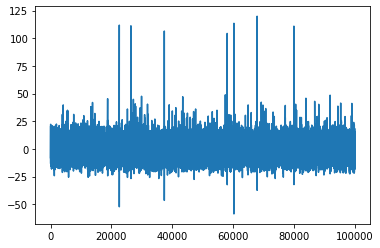

In [87]:
##
# Import data and plot first 100,000 datapoints
#

import numpy as np
import pylab as plot
import matplotlib.pyplot as plt

trace = np.load('./spike_sort/simulation_1.npy')
plt.plot(trace[:100000])
plt.show()

In [88]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    # extract spike waveforms
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]

                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [89]:
##
# Extract the spike windows
#

spike_samp, wave_form = get_spikes(trace, tf=6)

In [90]:
# tryminmaxscaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler2 = MinMaxScaler()
scaledwave_form = scaler2.fit_transform(wave_form.T).T


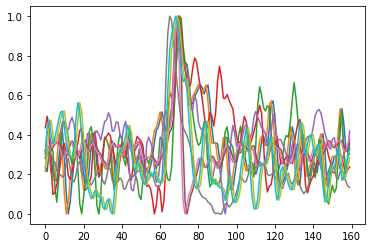

In [91]:
##
# Plot a few spike windows
#

#plt.plot(wave_form[:10].T)
plt.plot(scaledwave_form[:10].T)

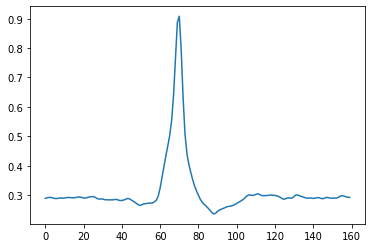

In [92]:
##
# Plot the average spike window
#

plt.plot(scaledwave_form.mean(axis=0))

Text(0, 0.5, 'cumulative explained variance')

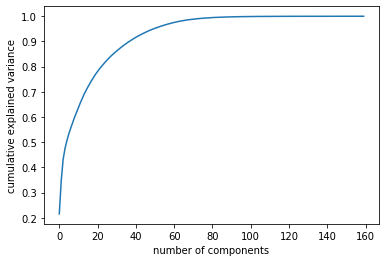

In [93]:
##
# Run PCA on wave forms
#

from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components = 2)
projected = pca.fit_transform(scaledwave_form)

In [94]:
from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components = 100)
X2D = pca.fit_transform(scaledwave_form)

#principalDf = pd.DataFrame(data = X2D)

#finalDf = pd.concat([principalDf, trace[['target']]], axis = 1)

#fig = plt.figure(figsize = (8,8))
#ax = fig.add_subplot(1,1,1) 
#ax.set_xlabel('Principal Component 1', fontsize = 15)
#ax.set_ylabel('Principal Component 2', fontsize = 15)
#ax.set_title('2 component PCA', fontsize = 20)
#ax.scatter(principalDf.loc['principal component 1']
 ##              , principalDf.loc['principal component 2']
   #            , s = 50)
#ax.grid()

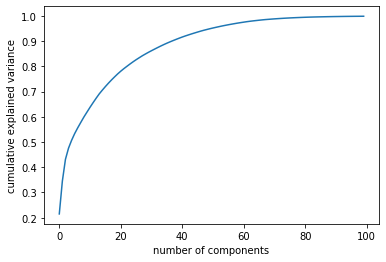

In [95]:
from numpy import cumsum
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [96]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, init="k-means++")
y_pred = kmeans.fit_predict(X2D)
#Each instance was assigned to one of the 5 clusters:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [97]:
y_pred is kmeans.labels_

True

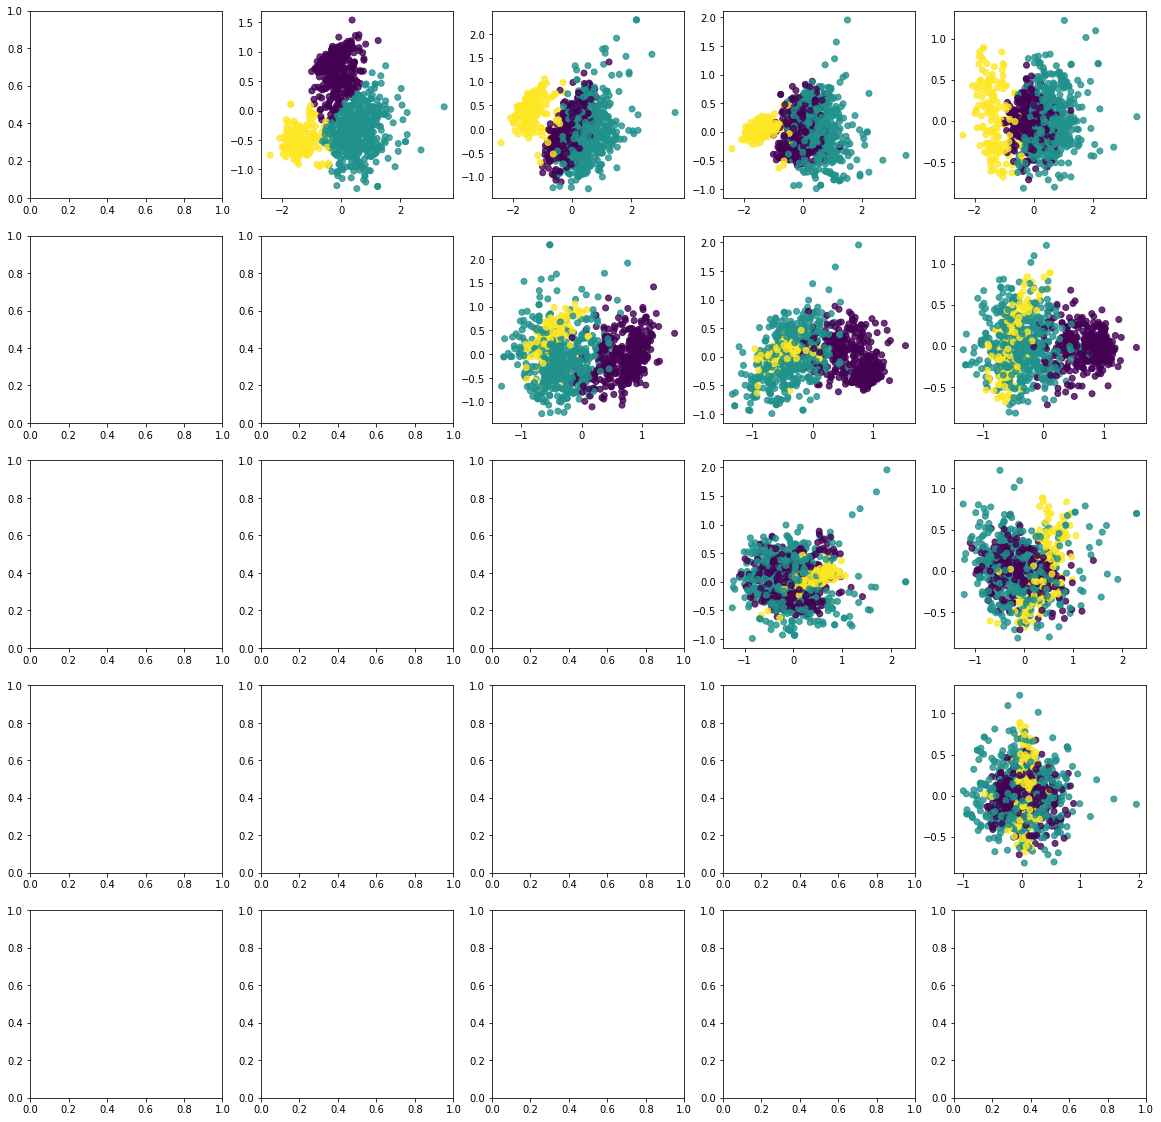

In [98]:
p = 0
q = 5
fig, axs = plt.subplots(q-p, q-p, figsize=(20,20))
for i in range(0, q-p):
    for j in range(i+1, q-p):
        axs[i, j].scatter(X2D[:, p+i], X2D[:, p+j], alpha=.8, c=kmeans.labels_)

In [99]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X2D[:,0:80])
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

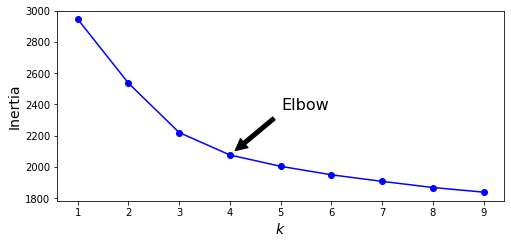

In [100]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
#plt.axis([1, 8.5, 0, 1300])
plt.show()

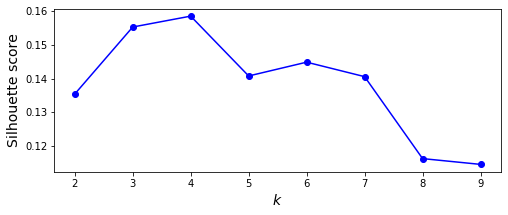

In [101]:
from sklearn.metrics import silhouette_score

silhouette_score(X2D[:,0:80], kmeans.labels_)

silhouette_scores = [silhouette_score(X2D[:,0:80], model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Text(0.5, 1.0, 'The total number of spikes for the first neuron is 369')

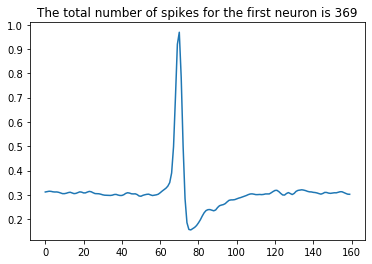

In [102]:
##
# Plot first neuron response
#

from numpy import mean

firstcom = sum((kmeans.labels_ == 0).astype(int))

plt.plot(mean(scaledwave_form[kmeans.labels_==0], axis=0))
plt.title("The total number of spikes for the first neuron is " + str(firstcom))

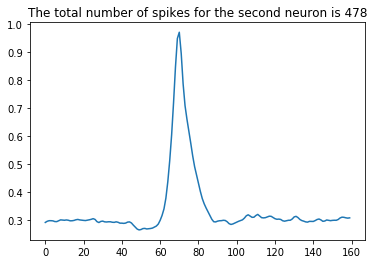

In [103]:
##
# Plot second neuron response
#

from numpy import mean
firstcom = sum((kmeans.labels_ == 1).astype(int))

plt.title("The total number of spikes for the second neuron is " + str(firstcom))

plt.plot(mean(scaledwave_form[kmeans.labels_==1], axis=0))

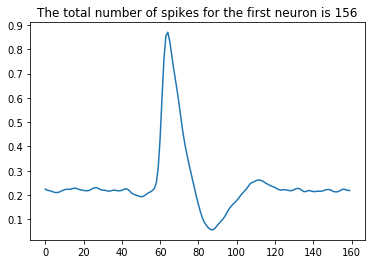

In [104]:
##
# Plot third neuron response
#

from numpy import mean
firstcom = sum((kmeans.labels_ == 2).astype(int))

plt.title("The total number of spikes for the third neuron is " + str(firstcom))

plt.plot(mean(scaledwave_form[kmeans.labels_==2], axis=0))

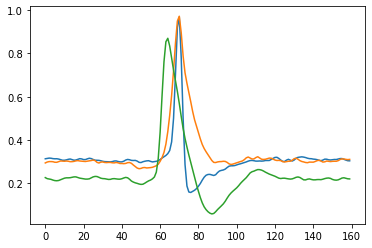

In [105]:
##
# Plot all neuron responses
#

from numpy import mean

plt.plot(mean(scaledwave_form[kmeans.labels_==0], axis=0))
plt.plot(mean(scaledwave_form[kmeans.labels_==1], axis=0))
plt.plot(mean(scaledwave_form[kmeans.labels_==2], axis=0))

In [116]:
### LLE
from sklearn.manifold import Isomap
#n_neighbors =10,
Imap = Isomap(n_components = 20)
datas2 = Imap.fit_transform(scaledwave_form)

from sklearn.cluster import KMeans

k = 3
kmeansLLE = KMeans(n_clusters=k, random_state=42, init="k-means++")
y_predLLE = kmeansLLE.fit_predict(datas2)
#Each instance was assigned to one of the 5 clusters:
y_predLLE

y_predLLE is kmeansLLE.labels_

True

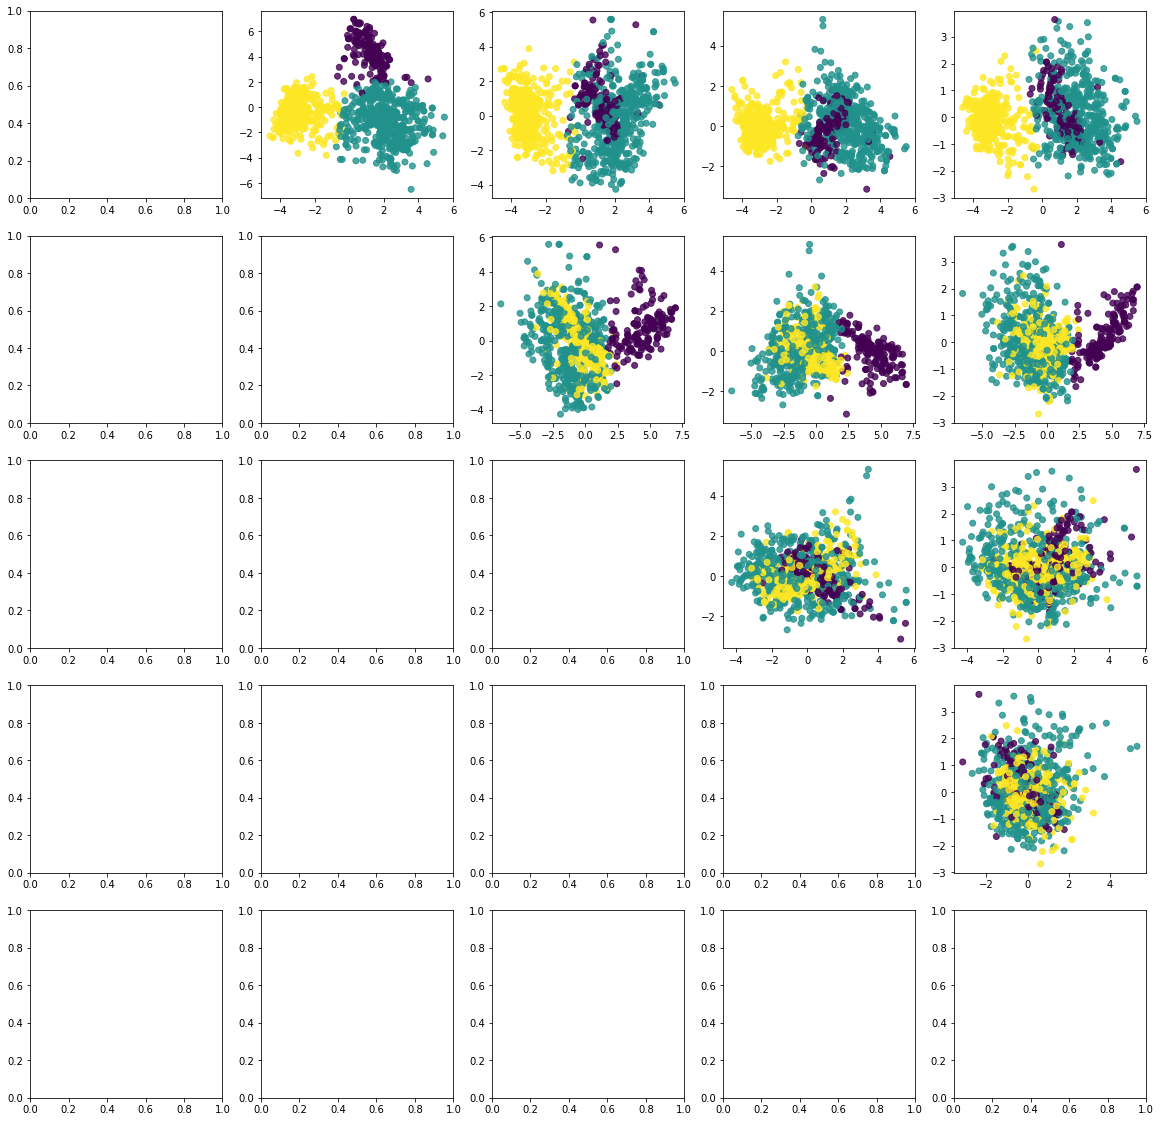

In [117]:
p = 0
q = 5
fig, axs = plt.subplots(q-p, q-p, figsize=(20,20))
for i in range(0, q-p):
    for j in range(i+1, q-p):
        axs[i, j].scatter(datas2[:, p+i], datas2[:, p+j], alpha=.8, c=kmeansLLE.labels_)

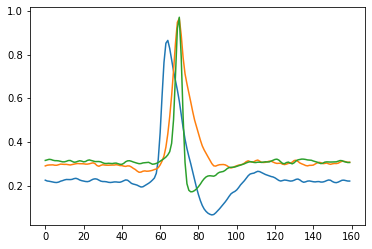

In [118]:
##
# Plot all neuron responses
#

from numpy import mean

plt.plot(mean(scaledwave_form[kmeansLLE.labels_==0], axis=0))
plt.plot(mean(scaledwave_form[kmeansLLE.labels_==1], axis=0))
plt.plot(mean(scaledwave_form[kmeansLLE.labels_==2], axis=0))

In [119]:
firstcom = sum((kmeansLLE.labels_ == 0).astype(int))
secondcom = sum((kmeansLLE.labels_ == 1).astype(int))
thirdcom = sum((kmeansLLE.labels_ == 2).astype(int))

print("The total number of spikes for the first neuron is " + str(firstcom) + 
    " and The total number of spikes for the second neuron is " + str(secondcom) + 
    " and The total number of spikes for the third neuron is " + str(thirdcom)  
    )

The total number of spikes for the first neuron is 160 and The total number of spikes for the second neuron is 453 and The total number of spikes for the third neuron is 390
